In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [10]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, num_classes)
        # 创建两层卷积

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # 取出特征和节点与对应节点的索引
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # 通过第一层图卷积并进行非线性和dropout操作
        # 这里需要传入x和edge_index两个参数 分别代表初始特征和连接关系
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)
        # 通过第二层图卷积并应用log_softmax防止数值不稳定

In [12]:
model = GCN(num_features=dataset.num_node_features,
            num_classes=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# 构建模型并使用Adam优化器

In [13]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()
    # 训练模型

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    # 取出可能性最大的类别
    
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    # 计算准确率
    
    return acc

In [14]:
losses = []
accuracies = []

for epoch in range(1,101):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    # 方便后续画图用
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc*100:.2f}')
        # 每十个epoch计算一次准确率

Epoch: 10, Loss: 0.9432, Acc: 72.10
Epoch: 20, Loss: 0.2745, Acc: 75.80
Epoch: 30, Loss: 0.1846, Acc: 77.80
Epoch: 40, Loss: 0.0925, Acc: 76.00
Epoch: 50, Loss: 0.0777, Acc: 77.40
Epoch: 60, Loss: 0.0414, Acc: 76.60
Epoch: 70, Loss: 0.0434, Acc: 77.40
Epoch: 80, Loss: 0.0396, Acc: 77.30
Epoch: 90, Loss: 0.0521, Acc: 77.10
Epoch: 100, Loss: 0.0619, Acc: 77.00


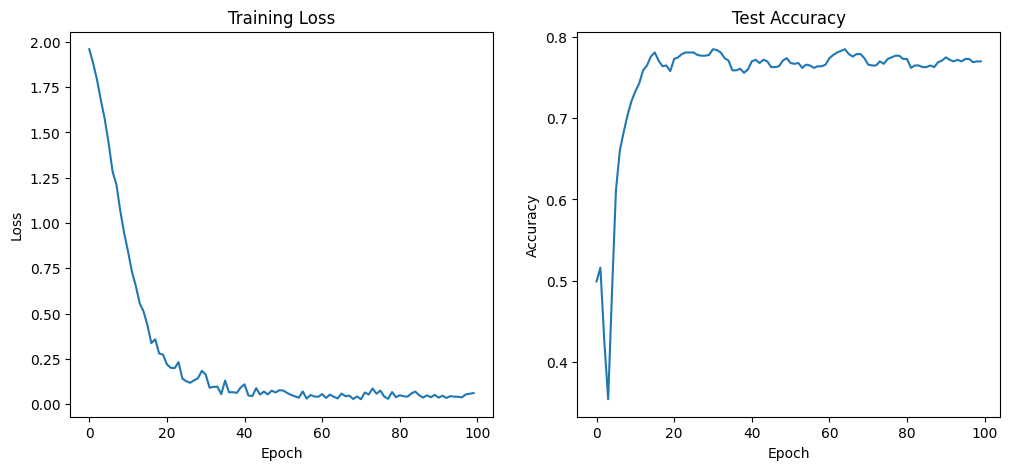

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [16]:

model.eval()
out = model(data)
pred = out.argmax(dim=1)

test_indices = data.test_mask.nonzero(as_tuple=True)[0]
test_indices = test_indices[torch.randperm(test_indices.size(0))]
# 提取测试集的节点索引并随机排列其顺序

for idx in test_indices[:5]:
    print(f'Node {idx.item()}: Predicted class {pred[idx].item()}, True class {data.y[idx].item()}')

Node 1765: Predicted class 2, True class 2
Node 2579: Predicted class 3, True class 3
Node 1710: Predicted class 2, True class 2
Node 2262: Predicted class 4, True class 4
Node 2195: Predicted class 5, True class 0
